In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
# make plots have a dark theme
plt.style.use('dark_background')
import glob
from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.cosmology import LambdaCDM, z_at_value
cosmo = LambdaCDM(H0=69.6, Om0=0.286, Ode0=0.714)
h = 69.6/100

import sys
sys.path.append('/global/homes/c/clamman/IA/spec-IA/')
from alignment_functions.gal_groups import *
from geometry_functions.coordinate_functions import *
from visualization_functions import *
from alignment_functions.general_stats import *
from alignment_functions.basic_alignment import *

import seaborn as sns

In [2]:
scratch_path = '/pscratch/sd/c/clamman/'

In [3]:
desi_catalog = Table.read(scratch_path+'Iron_LRG_noCircles.csv') 
desi_catalog.keep_columns(['RA', 'DEC', 'Z'])

In [ ]:
#desi_randoms = Table.read(scratch_path+'desi_randoms.fits')

### Finding groups

Find set of groups with: 
- transverse separations < 0.5 Mpc/h
- LOS separations < 6 Mpc/h
- (optional) no other groups within 1 Mpc/h transverse  (** no other galaxy)

In [4]:
desi_points = get_cosmo_points(desi_catalog)  # convert to comoving cartesian points in Mpc/h, assumes oberver is at orgin

In [113]:
# group PARAMETERS

# requirements for group members relative to center of group
transverse_max = 1 #0.5, .75, 1                           
los_max = 12 #6, 9, 12

group_transverse_minSep = transverse_max * 2  # minimum separation between groups
group_los_minSep = los_max * 2                # minimum separation between groups
max_n = 100                                    # maximum number of group members. relistically this doesn't go above 10

In [114]:
# finding initial group list
desi_groups = find_groups_UnionFind(desi_points, max_n = max_n, transverse_max = transverse_max, los_max = los_max)

In [115]:
desi_groups_isolated = get_isolated_groups(desi_points, desi_groups, group_transverseSep_min=group_transverse_minSep, group_losSep_min=group_los_minSep)

Number of groups found:  123693
	Group Requirements
	maximum transverse between group members:	 1  Mpc/h 
	maximum los distance between group members:		 12  Mpc/h
Number of isolated groups:  113286
	Isolated group requirements
	minimum distance between group center and a galaxy outside the group:	 2  Mpc/h 
	minimum distance between group and another group: 24  Mpc/h


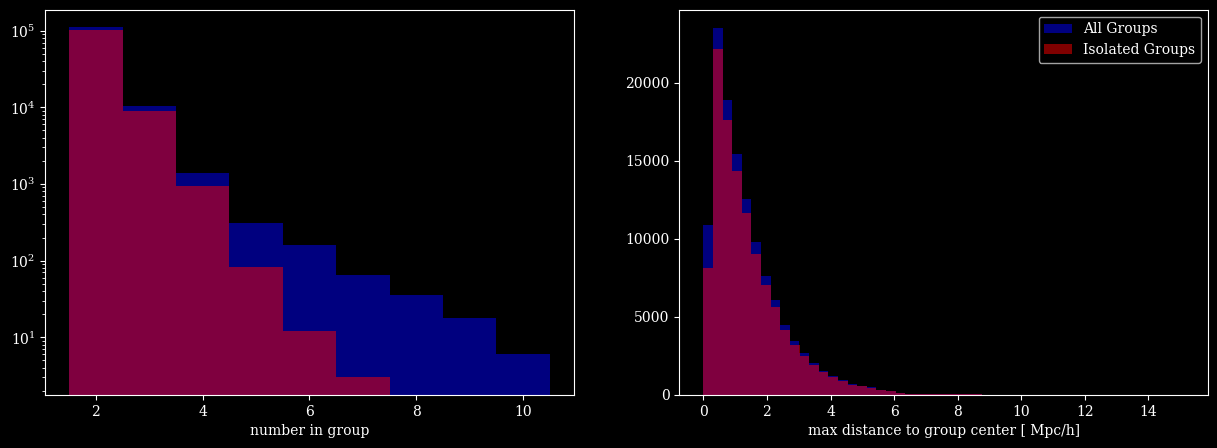

In [118]:
points = desi_points

# plot summaries of groups
print('Number of groups found: ', len(desi_groups))
print('\tGroup Requirements\n\tmaximum transverse between group members:\t', transverse_max, ' Mpc/h',
      '\n\tmaximum los distance between group members:\t\t', los_max, ' Mpc/h')
print('Number of isolated groups: ', len(desi_groups_isolated))
print('\tIsolated group requirements\n\tminimum distance between group center and a galaxy outside the group:\t', group_transverse_minSep, ' Mpc/h',
      '\n\tminimum distance between group and another group:', group_los_minSep, ' Mpc/h')

# look at groupemographics
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist([len(cl) for cl in desi_groups], alpha=.5, label='All Cluters', bins=np.arange(1.5, 11, 1), color='b')
plt.hist([len(cl) for cl in desi_groups_isolated], alpha=.5, label='Isolated Cluters', bins=np.arange(1.5, 11, 1), color='r')
plt.xlabel('number in group')
plt.yscale('log')

plt.subplot(122)
plt.xlabel('max distance to group center [ Mpc/h]')
# find the maximum distance between group members
group_distances = []
for cl in desi_groups:
    group_center = np.mean(points[cl], axis=0)
    distance_to_center = np.linalg.norm(points[cl] - group_center, axis=1)
    group_distances.append(np.max(distance_to_center))
plt.hist(group_distances, alpha=.5, label='All Groups', bins=50, color='b');

group_distances_isolated = []
for cl in desi_groups_isolated:
    group_center = np.mean(points[cl], axis=0)
    distance_to_center = np.linalg.norm(points[cl] - group_center, axis=1)
    group_distances_isolated.append(np.max(distance_to_center))
plt.hist(group_distances_isolated, alpha=.5, label='Isolated Groups', bins=50, color='r');
plt.legend()

fig.savefig('plots/group_stats3.png', bbox_inches='tight')

### Measuring Group Alignment

In [119]:
# getting group orientations

def make_group_table(points, group_indices):
    group_table = Table()
    group_table['center_loc'] = [np.mean(points[cl], axis=0) for cl in group_indices]
    group_table['orientation'] = [calculate_2D_group_orientation(points[cl]) for cl in group_indices]
    group_table['n_group'] = [len(cl) for cl in group_indices]
    group_table['max_dist_to_center'] = [np.max(np.linalg.norm(points[cl] - group_table['center_loc'][i], axis=1)) for i, cl in enumerate(group_indices)]
    return group_table

group_table = make_group_table(points, desi_groups)
group_table_isolated = make_group_table(points, desi_groups_isolated)

In [129]:
group_seps, group_paRel = rel_angle_regions(ang_tracers = group_table['center_loc'], ang_values = group_table['orientation'], n_regions=30,
                                                      loc_tracers = desi_points, pimax = 20, max_proj_sep = 150, max_neighbors=1000)
group_seps_isolated, group_paRel_isolated = rel_angle_regions(ang_tracers = group_table_isolated['center_loc'], ang_values = group_table_isolated['orientation'], n_regions=30,
                                                        loc_tracers = desi_points, pimax = 20, max_proj_sep = 150, max_neighbors=1000)

/global/u1/c/clamman/IA/spec-IA/geometry_functions/coordinate_functions.py:137: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


In [134]:
# bin results
nbins=20
sep_bins, ang_plot_all, ang_plot_e_all = bin_region_results(group_seps, group_paRel, nbins=nbins, log_bins=True)
sep_bins_isolated, ang_plot_isolated_all, ang_plot_e_isolated_all = bin_region_results(group_seps_isolated, group_paRel_isolated, nbins=nbins, log_bins=True)

In [135]:
ang_plot = np.nanmean(ang_plot_all, axis=0)
ang_plot_e = np.nanstd(ang_plot_all, axis=0) / np.sqrt(len(ang_plot_all))

ang_plot_isolated = np.nanmean(ang_plot_isolated_all, axis=0)
ang_plot_e_isolated = np.nanstd(ang_plot_isolated_all, axis=0) / np.sqrt(len(ang_plot_isolated_all))

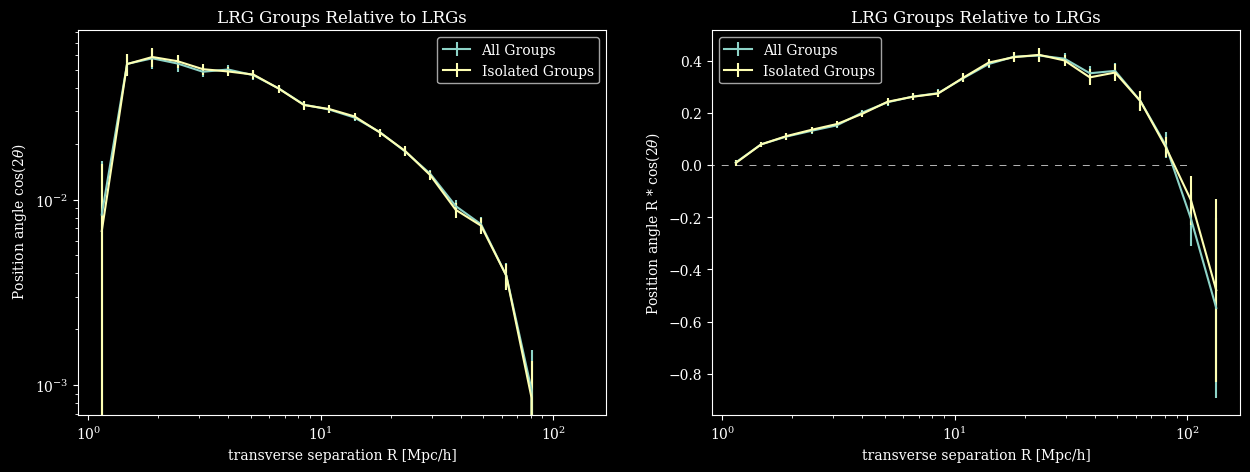

In [141]:
fig = plt.figure(figsize=(15,5))
# find the midpoint of the bins
xvalues = (sep_bins[1:] + sep_bins[:-1])/2

plt.subplot(121)
plt.title("LRG Groups Relative to LRGs")
plt.errorbar(xvalues, ang_plot, yerr=ang_plot_e, label='All Groups');
plt.errorbar(xvalues, ang_plot_isolated, yerr=ang_plot_e_isolated, label='Isolated Groups');
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle cos(2$\theta$)')
plt.legend()


plt.subplot(122)
plt.title("LRG Groups Relative to LRGs")
plt.errorbar(xvalues, xvalues*ang_plot, yerr=xvalues*ang_plot_e, label='All Groups');
plt.errorbar(xvalues, xvalues*ang_plot_isolated, yerr=xvalues*ang_plot_e_isolated, label='Isolated Groups');
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r'Position angle R * cos(2$\theta$)')
plt.xscale('log')
# add dotted line at 0
# make dashes far apart
plt.plot([0,100], [0,0], color='w', linewidth=.5, zorder=0, dashes=(10, 10))

plt.legend();

fig.savefig('plots/LRG_group_alignment3_150_log.png', bbox_inches='tight', dpi=200);

In [148]:
# switch matplotlib theme to white
plt.style.use('default')

plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'

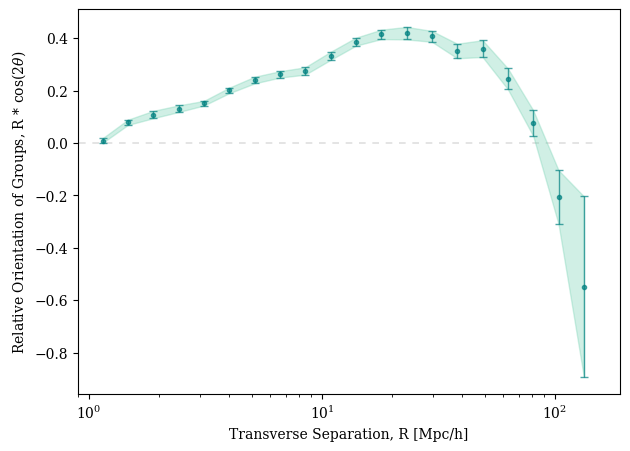

In [164]:
fig = plt.figure(figsize=(7,5))

# plot the errorbars as a shaded region
plt.fill_between(xvalues, xvalues*(ang_plot-ang_plot_e), xvalues*(ang_plot+ang_plot_e), alpha=.3, color='mediumaquamarine');

plt.errorbar(xvalues, xvalues*ang_plot, yerr=xvalues*ang_plot_e, label='All Groups', alpha=.7, color='teal', 
             linestyle='None', marker='o', markersize=3, capsize=3, elinewidth=1);
plt.xlabel('Transverse Separation, R [Mpc/h]')
plt.ylabel(r'Relative Orientation of Groups, R * cos(2$\theta$)')
plt.xscale('log')
# add dotted line at 0
# make dashes far apart
plt.plot([0,150], [0,0], color='grey', linewidth=.3, zorder=0, dashes=(16,16))

fig.savefig('plots/LRG_group_alignment3_150_log_single.png', bbox_inches='tight', dpi=200);

In [133]:
# save results
# plot summaries of groups

groups1_filename = scratch_path+'group_measurements/LRG_groups3_150.txt'
groups2_filename = scratch_path+'group_measurements/LRG_groups3_isolated_150.txt'

with open(groups1_filename, 'w') as f:
      # make header
      f.write('Number of groups found: '+str(len(desi_groups)))
      f.write('\nGroup Requirements\n\tmaximum transverse between group members: \t'+str(transverse_max)+' Mpc/h'+
      '\n\tmaximum los distance between group members: \t\t'+str(los_max)+ ' Mpc/h\n')
      
      # write data
      f.write('\n R_sep (Mpc/h) \n')
      f.writelines([str(value)+',' for value in sep_bins])
      f.write('\n cos(2*theta) \n')
      f.writelines([str(value)+',' for value in ang_plot_all])

with open(groups2_filename, 'w') as f:
      # make header
      f.write('Number of isolated groups found: '+str(len(desi_groups_isolated)))
      f.write('\nGroup Requirements\n\tmaximum transverse between group members: \t'+str(transverse_max)+' Mpc/h'+
      '\n\tmaximum los distance between group members: \t\t'+str(los_max)+ ' Mpc/h\n')
      f.write('\nIsolated group requirements\n\tminimum distance between group center and a galaxy outside the group: \t'+str(group_transverse_minSep)+' Mpc/h'+
      '\n\tminimum distance between group and another group: \t'+str(group_los_minSep)+ ' Mpc/h\n')
      
      # write data
      f.write('\n R_sep (Mpc/h) \n')
      f.writelines([str(value)+',' for value in sep_bins_isolated])
      f.write('\n cos(2*theta) \n')
      f.writelines([str(value)+',' for value in ang_plot_isolated_all])

## Cov matrix

In [125]:
import pandas as pd

In [126]:
def plot_IA_covMatrix(binx, signal, title='', save=False, save_name='IA_covMatrix.png', subtract_identity=True):
    '''results_paths is to file of results from measure_alignment'''
    fig = plt.figure(figsize=(10, 7))
    lbs=15; fts=18
    #plt.title(r"$\epsilon'_1$ Reduced Covariance Matrix")
    plt.xlabel(r'Transverse Separation R [$h^{-1}$Mpc]', fontsize=fts); plt.ylabel(r'Transverse Separation R [$h^{-1}$Mpc]', fontsize=fts)
    
    #binx = np.logspace(-1, 1.6, 21)
    
    cv_kk = get_cov_matrix_from_regions(signal)
    
    
    # plot the heatmap and annotation on it
    labels = [[str(round(m, 3)), ' ', '', ''] for m in binx[::4]]
    
    labels = vstack(labels)['col0']
    
    to_subtract = np.identity(len(binx))
    if subtract_identity == False:
        to_subtract = 0

    #labels = np.linspace(0, 0.5, 6)
    #print(np.sort(np.linalg.eigvals(cv_kk)
    ax = sns.heatmap(cv_kk-to_subtract, cmap='twilight_shifted', xticklabels=labels, yticklabels=labels, vmax=.1, vmin=-.1)#, alpha=.9)
    #ax = sns.heatmap(cv_kk-np.identity(len(binx)), cmap='PuOr', xticklabels=labels, yticklabels=labels, vmax=1, vmin=-1)#, alpha=.9)

    ax.set_aspect('equal')
    #print(np.shape(cv_kk-np.identity(len(binx))))
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=lbs)
    plt.title(title, fontsize=fts)
    plt.xlabel('Projected Separation $r_p$ [$h^{-1}$Mpc]'); plt.ylabel('Projected Separation $r_p$ [$h^{-1}$Mpc]');#, annot=True)
    
    return cv_kk-np.identity(len(binx))

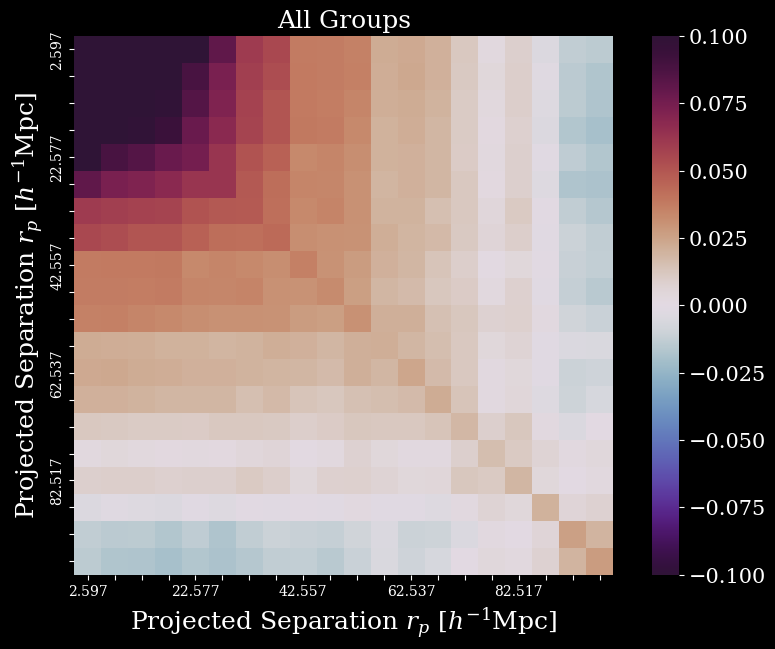

In [127]:
plot_IA_covMatrix(binx=xvalues, signal=np.asarray(ang_plot_all), title='All Groups', save=False, subtract_identity=False);

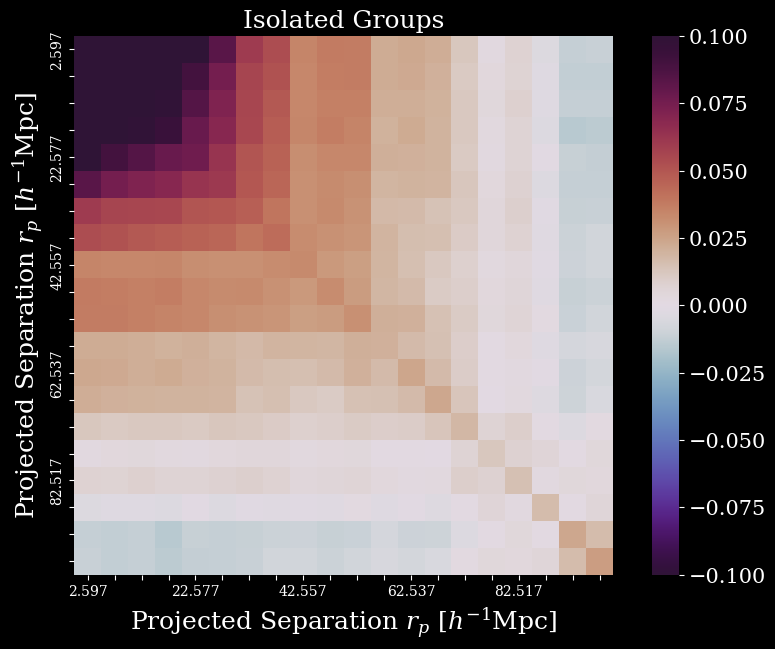

In [128]:
plot_IA_covMatrix(binx=xvalues, signal=np.asarray(ang_plot_isolated_all), title='Isolated Groups', save=False, subtract_identity=False);

### group-group alignment

In [32]:
group_seps, group_paRel = calculate_rel_ang_cartesian(ang_tracers = group_table['center_loc'], ang_values = group_table['orientation'], 
                                                      loc_tracers = group_table['center_loc'], pimax = 20, max_proj_sep = 100, max_neighbors=1000)
group_seps_isolated, group_paRel_isolated = calculate_rel_ang_cartesian(ang_tracers = group_table_isolated['center_loc'], ang_values = group_table_isolated['orientation'],
                                                        loc_tracers = group_table_isolated['center_loc'], pimax = 20, max_proj_sep = 100, max_neighbors=1000)

/global/u1/c/clamman/IA/spec-IA/geometry_functions/coordinate_functions.py:137: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


(3271098, 2)
(523174, 2)


In [33]:
# bin results
nbins=20
sep_bins = np.linspace(0.001, np.max(100), nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(group_seps, np.cos(2*group_paRel), sep_bins, statistic='mean', err=True)
ang_plot_isolated, ang_plot_e_isolated = bin_sum_not_scipy(group_seps_isolated, np.cos(2*group_paRel_isolated), sep_bins, statistic='mean', err=True)

/tmp/ipykernel_784355/4057438796.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,100], [0,0], 'k--', color='w', linewidth=.5, zorder=0, dashes=(10, 10))


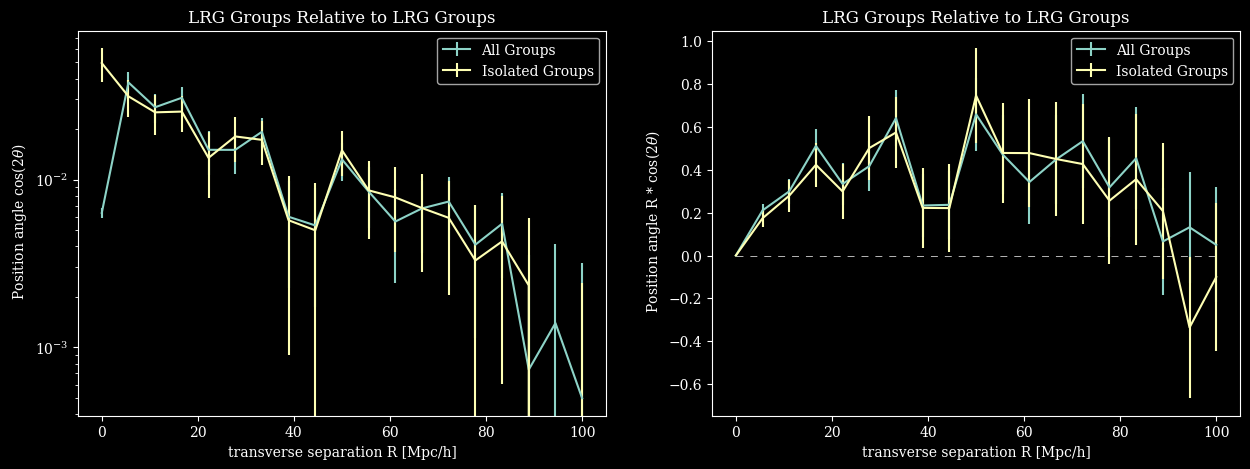

In [34]:
fig = plt.figure(figsize=(15,5))
xvalues = np.linspace(0, 100, nbins-1)

plt.subplot(121)
plt.title("LRG Groups Relative to LRG Groups")
plt.errorbar(xvalues, ang_plot, yerr=ang_plot_e, label='All Groups');
plt.errorbar(xvalues, ang_plot_isolated, yerr=ang_plot_e_isolated, label='Isolated Groups');
plt.yscale('log')
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle cos(2$\theta$)')
plt.legend()


plt.subplot(122)
plt.title("LRG Groups Relative to LRG Groups")
plt.errorbar(xvalues, xvalues*ang_plot, yerr=xvalues*ang_plot_e, label='All Groups');
plt.errorbar(xvalues, xvalues*ang_plot_isolated, yerr=xvalues*ang_plot_e_isolated, label='Isolated Groups');
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle R * cos(2$\theta$)')
# add dotted line at 0
# make dashes far apart
plt.plot([0,100], [0,0], 'k--', color='w', linewidth=.5, zorder=0, dashes=(10, 10))

plt.legend();

#fig.savefig('plots/LRG_groupgroup_alignment.png', bbox_inches='tight')